数据加载和预处理

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models, callbacks
import os

# 设置随机种子确保结果可复现
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from datetime import datetime, timedelta

# 设置时间范围
start_date = datetime(2014, 1, 1)
end_date = datetime(2015, 12, 31)

# 加载价格数据
def load_price_data(file_path):
    price_data = pd.read_csv(file_path)
    price_data['Date'] = pd.to_datetime(price_data['Date'])
    # 根据时间范围过滤数据
    price_data = price_data[(price_data['Date'] >= start_date) & (price_data['Date'] <= end_date)]
    price_data.set_index('Date', inplace=True)
    return price_data

# 加载情感数据
def load_sentiment_data(file_path):
    sentiment_data = pd.read_csv(file_path)
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
    # 根据时间范围过滤数据
    sentiment_data = sentiment_data[(sentiment_data['Date'] >= start_date) & (sentiment_data['Date'] <= end_date)]
    sentiment_data.set_index('Date', inplace=True)
    return sentiment_data

# 假设文件路径
price_file = 'price/raw/AAPL.csv'
sentiment_file = 'sentiment/processed_sentiment_analysis_AAPL_20140101_20151231.csv'

# 加载数据
price_df = load_price_data(price_file)

sentiment_df = load_sentiment_data(sentiment_file)

# 显示前几行
print("Price Data:")
print(price_df.head())
print("\nSentiment Data:")
print(sentiment_df.head())

Price Data:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2014-01-02  79.382858  79.575714  78.860001  79.018570  73.522530   58671200
2014-01-03  78.980003  79.099998  77.204285  77.282860  71.907555   98116900
2014-01-06  76.778572  78.114288  76.228569  77.704285  72.299644  103152700
2014-01-07  77.760002  77.994286  76.845711  77.148575  71.782608   79302300
2014-01-08  76.972855  77.937141  76.955711  77.637146  72.237190   64632400

Sentiment Data:
           Sentiment                                           Analysis
Date                                                                   
2014-01-01  Negative  Okay, let me try to figure out how to analyze ...
2014-01-02  Negative  Okay, so I need to figure out the impact of th...
2014-01-03  Negative  Okay, I need to analyze these tweets and deter...
2014-01-04  Negative  Alright, I need to analyze these tweets to det...


特征工程

In [6]:
# 情感数据处理：将文本情感转换为数值
def encode_sentiment(sentiment_df):
    # 创建情感映射字典
    sentiment_mapping = {
        'Positive': 1.0,
        'Neutral': 0.0,
        'Negative': -1.0,
        'Missing': 0.0  # 没有新闻的天赋予中性情感
    }
    
    # 转换情感
    sentiment_df['Sentiment_Value'] = sentiment_df['Sentiment'].map(sentiment_mapping)
    
    # 创建额外的情感存在标记（有新闻 vs 没有新闻）
    sentiment_df['Has_News'] = (sentiment_df['Sentiment'] != 'Missing').astype(float)
    
    return sentiment_df

# 价格数据特征工程：计算技术指标
def engineer_price_features(price_df):
    # 添加价格变化
    price_df['Price_Change'] = price_df['Close'].pct_change()
    
    # 添加移动平均线
    price_df['MA5'] = price_df['Close'].rolling(window=5).mean()
    price_df['MA10'] = price_df['Close'].rolling(window=10).mean()
    
    # 添加成交量变化
    price_df['Volume_Change'] = price_df['Volume'].pct_change()
    
    # 添加价格波动率（过去5天）
    price_df['Volatility'] = price_df['Close'].rolling(window=5).std()
    
    # 添加价格动量（5天）
    price_df['Momentum'] = price_df['Close'] - price_df['Close'].shift(5)
    
    return price_df

# 合并价格和情感数据
def merge_data(price_df, sentiment_df):
    # 对数据应用特征工程
    sentiment_df = encode_sentiment(sentiment_df)
    price_df = engineer_price_features(price_df)
    
    # 合并数据框
    merged_df = price_df.join(sentiment_df[['Sentiment_Value', 'Has_News']], how='left')
    
    # 填充缺失值
    merged_df.fillna(0, inplace=True)
    
    # 删除包含NaN的行（通常是开始的几行，因为移动平均线需要足够的数据）
    merged_df.dropna(inplace=True)
    
    return merged_df

# 应用数据处理
processed_df = merge_data(price_df, sentiment_df)
print("\nProcessed Data:")
print(processed_df.head())


Processed Data:
                 Open       High  ...  Sentiment_Value  Has_News
Date                              ...                           
2014-01-02  79.382858  79.575714  ...             -1.0       1.0
2014-01-03  78.980003  79.099998  ...             -1.0       1.0
2014-01-06  76.778572  78.114288  ...              1.0       1.0
2014-01-07  77.760002  77.994286  ...             -1.0       1.0
2014-01-08  76.972855  77.937141  ...              1.0       1.0

[5 rows x 14 columns]


In [7]:
# 准备LSTM所需的序列数据
def create_sequences(data, time_steps=10):
    """
    将数据转换为LSTM可用的序列格式
    
    参数:
    - data: 包含特征和标签的DataFrame
    - time_steps: 序列的时间步长（回看天数）
    
    返回:
    - X: 特征序列
    - y: 目标标签（第二天股价是否上涨）
    """
    X, y = [], []
    
    # 特征列和目标列
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                   'Sentiment_Value', 'Has_News', 'Price_Change', 
                   'MA5', 'MA10', 'Volume_Change', 'Volatility', 'Momentum']
    
    # 构建目标变量：第二天价格是否上涨
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    
    # 确保没有NaN值
    data.dropna(inplace=True)
    
    # 获取特征数据
    raw_data = data[feature_cols].values
    target_data = data['Target'].values
    
    # 创建序列
    for i in range(len(data) - time_steps):
        X.append(raw_data[i:i+time_steps])
        y.append(target_data[i+time_steps])
    
    return np.array(X), np.array(y)

# 设置序列长度（过去几天的数据）
sequence_length = 10

# 创建序列数据
X, y = create_sequences(processed_df, time_steps=sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# 分割训练集和测试集（按时间顺序，使用前80%训练，后20%测试）
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 再划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

X shape: (494, 10, 13), y shape: (494,)
Training set: (316, 10, 13)
Validation set: (79, 10, 13)
Test set: (99, 10, 13)


In [11]:
# 构建LSTM模型
def build_lstm_model(input_shape, lstm_units=30):
    model = models.Sequential()
    
    # 第一个LSTM层带返回序列
    model.add(layers.LSTM(lstm_units, 
                   return_sequences=True, 
                   input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    
    # 第二个LSTM层
    model.add(layers.LSTM(lstm_units))
    model.add(layers.Dropout(0.2))
    
    # 输出层（二分类问题：股价上涨或下跌）
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 构建模型
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# 打印模型摘要
model.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 30)         │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,631 (49.34 KB)

 Trainable params: 12,631 (49.34 KB)

 Non-trainable params: 0 (0.00 B)

模型训练

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4553 - loss: 0.7116 - val_accuracy: 0.4177 - val_loss: 0.7177
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.6974 - val_accuracy: 0.4177 - val_loss: 0.7126
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5213 - loss: 0.6899 - val_accuracy: 0.4177 - val_loss: 0.7098
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4921 - loss: 0.7074 - val_accuracy: 0.4177 - val_loss: 0.7102
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.6942 - val_accuracy: 0.4177 - val_loss: 0.7183
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4901 - loss: 0.6944 - val_accuracy: 0.4177 - val_loss: 0.7179
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4588 - loss: 0.7033 - val_accuracy: 0.4177 - val_loss: 0.7098
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5426 - loss: 0.6914 - val_accuracy: 0.4177 - val_loss

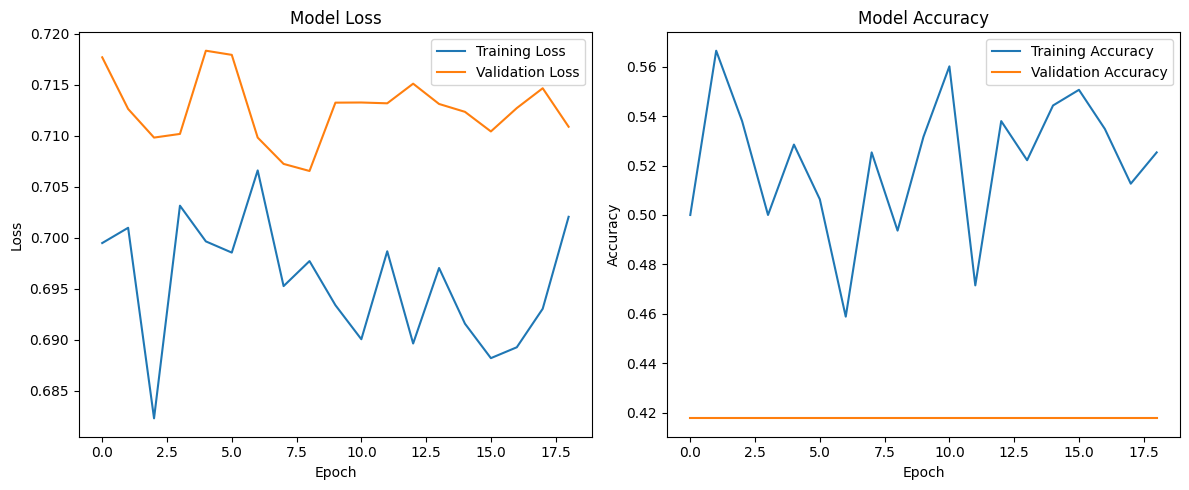

In [12]:
# 训练模型
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    # 早停策略，防止过拟合
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # 训练模型
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history

# 训练模型
history = train_model(model, X_train, y_train, X_val, y_val)

# 绘制训练历史
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

模型评估

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test Accuracy: 0.4444

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.44      1.00      0.62        44

    accuracy                           0.44        99
   macro avg       0.22      0.50      0.31        99
weighted avg       0.20      0.44      0.27        99


Confusion Matrix:
[[ 0 55]
 [ 0 44]]


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

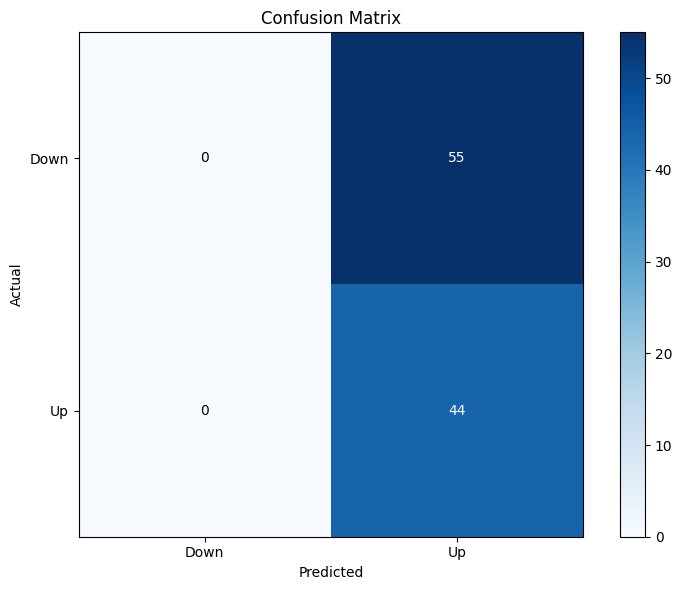

In [13]:
# 评估模型性能
def evaluate_model(model, X_test, y_test):
    # 获取测试集预测
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # 计算准确率
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # 从sklearn导入评估指标
    from sklearn.metrics import classification_report, confusion_matrix
    
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 计算并打印混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0, 1], ['Down', 'Up'])
    plt.yticks([0, 1], ['Down', 'Up'])
    
    # 在每个单元格中添加文本
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_pred_proba

# 评估模型
y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)